In [3]:
from pmag_env import set_env
from pmagpy import pmag
from pmagpy import pmagplotlib
import pmagpy.ipmag as ipmag
from pmagpy import pmagplotlib
import os
import fnmatch
import itertools

In [4]:
import numpy as np
import time
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from datetime import datetime as dt
import sys
import math
from functools import reduce
# makes the plots come up in window
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#from mpl_toolkits.basemap import Basemap

In [3]:
def ffunc(pars_1, pars_2,pars_both):
    """
    Calculate the McFadden and Lowe f test statistic. Calculated as r*((R_one+R_two)**2 - R_mean**2)/(2*((N_one-R_one) + r*(N_two-R_two))*(R_one + r*R_two))
    Parameters
    ----------
    pars_1 : dictionary of Fisher statistics from population 1
    pars_2 : dictionary of Fisher statistics from population 2
    
    Returns
    -------
    f_stat : McFadden and Lowe f statistic
    f_prob : the value that must be exceeded to overturn the null hypothesis 
    """
    #getting the necessary numbers from each dictionary, and the ratio of precision parameters
    R_one=pars_1['r']
    N_one=pars_1['n']
    R_two=pars_2['r']
    N_two=pars_2['n']
    r_ratio=pars_2['k']/pars_1['k']

    #now getting R and N for the combined dataset
    R_mean = pars_both['r']
    N_mean = pars_1['n']+pars_2['n']

    f_stat = r_ratio*((R_one+R_two)**2 - R_mean**2)/(2*((N_one-R_one) + r_ratio*(N_two-R_two))*(R_one + r_ratio*R_two))
    
    #default is testing at 95% level of confidence
    return f_stat

In [16]:
def common_mean_mclow(Data1, Data2, NumSims=5000, print_result=True,plot='yes',save=False):
    """
    Conduct the McFadden and Lowes (1981) f test for a common mean on two directional data sets.
    This function calculates the M+L(1981) f statistic from input files through
    Monte Carlo simulation in order to test whether two populations of
    directional data could have been drawn from a common mean. The f statistic and the 
    angle between the two sample mean directions and the corresponding
    McFadden and McElhinny (1990) classification is printed.
    Parameters
    ----------
    Data1 : a nested list of directional data [dec,inc] (a di_block)
    Data2 : a nested list of directional data [dec,inc] (a di_block)
    NumSims : number of Monte Carlo simulations (default is 5000)
    print_result : default is to print the test result (True)
    
    Returns
    -------
    printed text : text describing the test result is printed
    result : a boolean where 0 is fail and 1 is pass
    """
    pars_1 = pmag.fisher_mean(Data1)
    pars_2 = pmag.fisher_mean(Data2)
    pars_both = pmag.fisher_mean(Data1+Data2)
    
    R_one=pars_1['r']
    N_one=pars_1['n']
    R_two=pars_2['r']
    N_two=pars_2['n']
    r_ratio=pars_2['k']/pars_1['k']

    #now getting R and N for the combined dataset
    R_mean = pars_both['r']
    N_mean = pars_both['n']

    f_stat = r_ratio*((R_one+R_two)**2 - R_mean**2)/(2*((N_one-R_one) + r_ratio*(N_two-R_two))*(R_one + r_ratio*R_two))
    
    #default is testing at 95% level of confidence
    p_conf = .05

    f_prob = (1/p_conf)**(1/(N_mean-2)) - 1
    
    counter = 0
    f_stat_sims = []  # set of f_stat from simulations
    for k in range(NumSims):

        # get a set of N1 fisher distributed vectors with k1,
        # calculate fisher stats
        Dirp = []
        for i in range(pars_1['n']):
            Dirp.append(pmag.fshdev(pars_1['k']))
        pars_p1 = pmag.fisher_mean(Dirp)
        Dirp1=Dirp
    # get a set of N2 fisher distributed vectors with k2,
    # calculate fisher stats
        Dirp = []
        for i in range(pars_2['n']):
            Dirp.append(pmag.fshdev(pars_2['k']))
        pars_p2 = pmag.fisher_mean(Dirp)
        Dirp2=Dirp
        pars_pboth= pmag.fisher_mean(Dirp1+Dirp2)
    # get the V for these
        f_sim = ffunc(pars_p1, pars_p2,pars_pboth)
        f_stat_sims.append(f_sim)

    # sort the Vs, get Vcrit (95th percentile one)

    f_stat_sims.sort()
    k = int(.95 * NumSims)
    fcrit = f_stat_sims[k]
    
    
    if print_result == True:
        print("Results of McFadden and Lowe f test: ")
        print("")
        print("Mc-Low f:           " '%.3f' % (f_stat))
        print("Critical value of f:  " '%.3f' % (fcrit))
   
    
    if f_stat < fcrit:
        if print_result == True:
            print('"Same direction": Since f does not exceed our test statistic,')
            print('the null hypothesis that the two true mean directions are the same')
            print('cannot be rejected at the chosen level of confidence.')
        result = 1
    elif f_stat > fcrit:
        if print_result == True:
            print('"Different direction": Since f does exceed our test statistic,')
            print('the null hypothesis that the two true mean directions are the same')
            print('can be rejected at the chosen level of confidence')
        result = 0
        
    if plot == 'yes':
        CDF = {'cdf': 1}
        # pmagplotlib.plot_init(CDF['cdf'],5,5)
        plt.figure(figsize=(3.5, 2.5))
        p1 = pmagplotlib.plot_cdf(CDF['cdf'], f_stat_sims, "Mc-Low f", 'r', "")
        p2 = pmagplotlib.plot_vs(CDF['cdf'], [f_stat], 'g', '-')
        p3 = pmagplotlib.plot_vs(CDF['cdf'], [f_stat_sims[k]], 'b', '--')
        p4 = pmagplotlib.plot_vs(CDF['cdf'], [f_prob], 'orange', '--')
        # pmagplotlib.draw_figs(CDF)
        if save == True:
            plt.savefig(os.path.join(
                save_folder, 'common_mean_mclow') + '.' + fmt)
        pmagplotlib.show_fig(CDF['cdf'])

In [26]:
directions_A = ipmag.fishrot(k=50, n=30, dec=45, inc=60)
directions_B = ipmag.fishrot(k=50, n=25, dec=42, inc=57)


Results of McFadden and Lowe f test: 

Mc-Low f:           0.013
Critical value of f:  0.059
"Same direction": Since f does not exceed our test statistic,
the null hypothesis that the two true mean directions are the same
cannot be rejected at the chosen level of confidence.


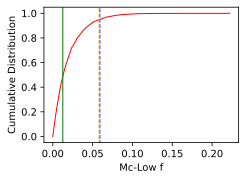

In [27]:
common_mean_mclow(directions_A,directions_B)

Results of Watson V test: 

Watson's V:           1.3
Critical value of V:  5.9
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 2.8
Critical angle for M&M1990:   5.9
The McFadden and McElhinny (1990) classification for
this test is: 'B'


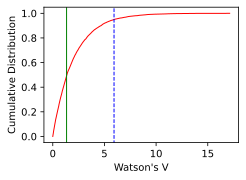

(1, 2.7931924226471945, 5.886870361253244)

In [28]:
ipmag.common_mean_watson(directions_A,directions_B,plot='yes')

In [ ]:
def plot_net_fancy(fignum=None):
    """
    Draws circle and tick marks for equal area projection.
    """

    if fignum != None:
        plt.figure(num=fignum,)
    plt.axis("off")
    Dcirc = np.arange(0, 361.)
    Icirc = np.zeros(361, 'f')
    Xcirc, Ycirc = [], []
    for k in range(361):
        XY = pmag.dimap(Dcirc[k], Icirc[k])
        Xcirc.append(XY[0])
        Ycirc.append(XY[1])
    plt.plot(Xcirc, Ycirc, 'k')
    
    for d in range(9):
        Dcirc = np.arange(0, 361.)
        Icirc = np.full(361,10*d, 'f')
        Xcirc, Ycirc = [], []
        for k in range(361):
            XY = pmag.dimap(Dcirc[k], Icirc[k])
            Xcirc.append(XY[0])
            Ycirc.append(XY[1])
        plt.plot(Xcirc, Ycirc, 'k',linewidth=0.25)
    
# put on the tick marks
    Xsym, Ysym = [], []
    for I in range(0,90,10):
        XY = pmag.dimap(0., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k_',linewidth=0.5)
    Xsym, Ysym = [], []
    for I in range(2, 90):
        XY = pmag.dimap(0., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym,Ysym, 'k', linewidth=0.25)
    Xsym, Ysym = [], []
    for I in range(0,90,10):
        XY = pmag.dimap(90., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k|',linewidth=0.1)
    Xsym, Ysym = [], []
    for I in range(2, 90):
        XY = pmag.dimap(90., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym,Ysym, 'k', linewidth=0.25)
    #the south axis
    Xsym, Ysym = [], []
    for I in range(0, 90, 10):
        XY = pmag.dimap(180., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k_',linewidth=0.5)
    Xsym, Ysym = [], []
    for I in range(2, 90):
        XY = pmag.dimap(180., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym,Ysym, 'k', linewidth=0.25)
    #the west axis
    Xsym, Ysym = [], []
    for I in range(0, 90, 10):
        XY = pmag.dimap(270., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k|',linewidth=0.5)
    Xsym, Ysym = [], []
    for I in range(2, 90):
        XY = pmag.dimap(270., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym,Ysym, 'k', linewidth=0.25)
    #declination ticks
    for D in range(0, 360, 15):
        Xtick, Ytick = [], []
        for I in range(85):
            XY = pmag.dimap(D, I)
            Xtick.append(XY[0])
            Ytick.append(XY[1])
        plt.plot(Xtick, Ytick, 'k',linewidth=0.5)
    plt.axis("equal")
    plt.axis((-1.05, 1.05, -1.05, 1.05))

In [35]:
def prob_simul(alpha,k1,k2):
    """
    runs the Bogue + Coe (1980) algorithm for probabilistic correlation. k1 and k2 can be naively estimated from kappa
    or one can use the function full_kappa to get a better estimate as in the original publication
    
    Parameters
    ----------
    
    alpha: angle between paleomagnetic directions (site means)
    k1: kappa estimate for first direction
    k2: kappa estimate for second direction
    
    Returns
    --------------------------
    
    simul_prob
    """
    trials=10000

    hit=0
    miss=0

    for i in range(trials):
        #FakeFish returns a list of [dec,inc]s, in this case just 1.
        lontp1,lattp1 = ipmag.fishrot(k1,1,0,90,di_block=False)
        lontp2,lattp2 = ipmag.fishrot(k2,1,0,90,di_block=False)
        angle=pmag.angle([lontp1[0],lattp1[0]],[lontp2[0],lattp2[0]])
        if (angle>=alpha):
            hit=hit+1
        else:
            miss=miss+1

    p1=1.0*hit/trials

    print ('Probability of simultaneous directions is: {0:5.3f}'.format(p1))

In [36]:
prob_simul(6.5,150,150)

Probability of simultaneous directions is: 0.621


In [55]:
def prob_rand(sec_var, delta1, delta2, alpha):

    """
    This function does a brute force numerical simulation of the 'random' hypothesis of Bogue + Coe (1981). Basically asks and answers
    the question: if we randomly sampled the ancient field, how frequently would we get two VGPs this far from pole and this
    close together? Originally written by Scott Bogue, translated into pmagpy functionality by Anthony Pivarunas
    
    Approach is:
    
    1. Assume VGP1 observed first
    #2. Pull a random direction from fisher distr. about mean pole with k
    #3. If within alpha of VGP1, hit.  If not, miss.
    #4. Repeat many times.
    #5. P(Hr)1=hit/(hit+miss)
    #
    #6. Now assume VGP2 observed first.
    #7. Repeat above steps, checking whether draw is within alpha of VGP2
    #8. P(Hr)2=hit/(hit+miss)
    #
    #9. P(Hr) is the average of P(Hr)1 and P(Hr)2
    
    Parameters
    ----------
    
    sec_var: k estimate of regional secular variation (probably 30 or 40)
    alpha: angle between paleomagnetic directions (or poles)
    delta1: distance of direction 1 from mean direction (or pole)
    delta2: distance of direction 2 from mean direction (or pole)
    
    Returns
    --------------------------
    
    rand_prob
    
    """

    trials=100000

    #calc probability of getting vgp within alpha of vgp1
    i=0
    miss=0
    hit=0
    for i in range(trials):
        dec,inc = ipmag.fishrot(sec_var,1,0,0,di_block=False)
        angle=pmag.angle([dec[0],inc[0]],[0,delta1])
        if (angle<=delta1):
            hit=hit+1
        else:
            miss=miss+1 

    prand1=(1.0*hit)/trials
    print ('P1(Hr): ',prand1)

    #calc probability of getting vgp within alpha of vgp2
    i=0
    hit=0
    miss=0
    for i in range(trials):
        dec,inc = ipmag.fishrot(sec_var,1,0,0,di_block=False)
        angle=pmag.angle([dec[0],inc[0]],[0,delta2])
        if (angle<=delta2):
            hit=hit+1
        else:
            miss=miss+1

    prand2=(1.0*hit)/trials
    print ('P2(Hr): ',prand2)

    #average of 2 is Prob of "Random Hypothesis"

    print ('The probability of the random hypothesis (average of P1 and P2) is: {0:5.3f}'.format((prand1+prand2)/2))


In [53]:
prob_rand(40,5,10,10)

P1(Hr):  0.1241
P2(Hr):  0.29319
P(Hr): 0.209


In [29]:
def full_kappa(original_k, sf, st):
    """
    This function uses a more 'full' uncertainty estimate to calculate the precision parameter
    (see Bogue and Coe, 1981) for details. original k is the usually reported estimate of the precision parameter kappa of a
    Fisher distribution. To it we add sf + st in quadrature. sf ( in degrees) is important for three categories of anomaly:
    flow anomalies as in Baag et al., 2002, regional magnetic anomalies, and non-dipole fields. st, the tectonic correction
    is both applicable in cases of later deformation, as well as assessing the stability of a given outcrop in recent volcanic
    terrains.
    
    Parameters
    ----------
    
    original_k : estimate of kappa, the Fisher distribution precision parameter 
    sf : magnetic anomaly contribution to difference (in degrees, probably between 0 and 1 except in rare cases)
    st : tectonic contribution to difference (in degrees, typically between 1-5)
    
    Returns
    -------
    full_kappa: 
    original_kappa:
    
    """
    sw = np.rad2deg(np.sqrt(2)/np.sqrt(original_k))
    s_bc1981_s2014 = np.sqrt(sf**2+sw**2+st**2)
    full_kappa = 2/(np.deg2rad(s_bc1981_s2014)**2)
    
    print("A more conservative estimate of kappa is {}, compared with {} using just random errors.".format(round(full_kappa),original_k))
    
    

In [30]:
full_kappa(4835, 0.5, 3.0)

A more conservative estimate of kappa is 619, compared with 4835 using just random errors.


In [31]:
help(full_kappa)

Help on function full_kappa in module __main__:

full_kappa(original_k, sf, st)
    This function uses a more 'full' uncertainty estimate to calculate the precision parameter
    (see Bogue and Coe, 1981) for details. original k is the usually reported estimate of the precision parameter kappa of a
    Fisher distribution. To it we add sf + st in quadrature. sf ( in degrees) is important for three categories of anomaly:
    flow anomalies as in Baag et al., 2002, regional magnetic anomalies, and non-dipole fields. st, the tectonic correction
    is both applicable in cases of later deformation, as well as assessing the stability of a given outcrop in recent volcanic
    terrains.
    
    Parameters
    ----------
    
    original_k : estimate of kappa, the Fisher distribution precision parameter 
    sf : magnetic anomaly contribution to difference (in degrees, probably between 0 and 1 except in rare cases)
    st : tectonic contribution to difference (in degrees, typically between 1